In [33]:
!pip install fbm --quiet

In [34]:
import numpy as np
import pandas as pd
from fbm import FBM
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import RANSACRegressor
from numpy.polynomial.polynomial import polyfit as polyfit_alt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
def multifractal_analysis(signal):
    # definicja wartości q
    Q = list(range(-10, 0)) + list(range(1, 11))

    # definicja wartości s (od 100 do 1/5 całości)
    S = [int(np.exp(i)) for i in np.linspace(np.log(150), np.log(len(signal) // 20), 100)]
    log_S = np.log(S).reshape(-1, 1)

    def get_variances(signal, s, q):

        # funkcja pomocnicza do ustacjonarnienia szeregu
        def process_blocks(blocks):
            x = np.arange(s)
            residuals_std = np.empty(len(blocks))
            for i, y in enumerate(blocks):
                coeffs = polyfit_alt(x, y, 2)
                residuals = y - (coeffs[0] + coeffs[1]*x + coeffs[2]*x**2)
                residuals_std[i] = np.std(residuals)
            return residuals_std

        # dzielenie na przedziały s -> od początku
        n = len(signal)
        n_blocks_fwd = n // s
        signal_fwd = signal[:n_blocks_fwd * s]
        blocks_fwd = signal_fwd.reshape(n_blocks_fwd, s)

        # dzielenie na przedziały s -> od końca
        n_blocks_bwd = n // s
        start = n - n_blocks_bwd * s
        signal_bwd = signal[start:]
        blocks_bwd = signal_bwd.reshape(n_blocks_bwd, s)

        res_fwd = process_blocks(blocks_fwd)
        res_bwd = process_blocks(blocks_bwd)

        all_res = np.concatenate([res_fwd, res_bwd])
        return np.mean(all_res ** q)

    # tutaj zbieranie wyników
    H = []

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)

    for q in tqdm(Q):
        vars_q = [get_variances(signal, s, q) for s in S]
        log_vars = np.log(vars_q)

        # filtr i dopasowanie prostej
        mask = ~np.isnan(log_vars)
        X, y = log_S[mask], log_vars[mask]
        ransac = RANSACRegressor(min_samples=0.8, max_trials=1000, random_state=42).fit(X, y)
        slope, intercept = ransac.estimator_.coef_[0], ransac.estimator_.intercept_

        H.append(slope / q)

        plt.plot(S, vars_q, color="k", label=f"q = {q}, f = {slope:.2f} * x")

    plt.title("Zależność średniej wariancji od długości przedziału S")
    plt.xlabel('S')
    plt.ylabel('Średnia wariancja')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize=8)

    # znalezienie spektrum multifraktalnego
    tau = np.array([q * h - 1 for q, h in zip(Q, H)])
    alfa = np.diff(tau) / np.diff(Q)
    f_alfa = np.array(Q[:-1]) * alfa - tau[:-1]

    # wykres spektrum
    plt.subplot(1, 2, 2)
    plt.scatter(alfa, f_alfa)
    plt.title('Spektrum multifraktalne')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$f(\alpha)$')
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Ułamkowy ruch Browna z H = 0.2

100%|██████████| 20/20 [01:02<00:00,  3.12s/it]


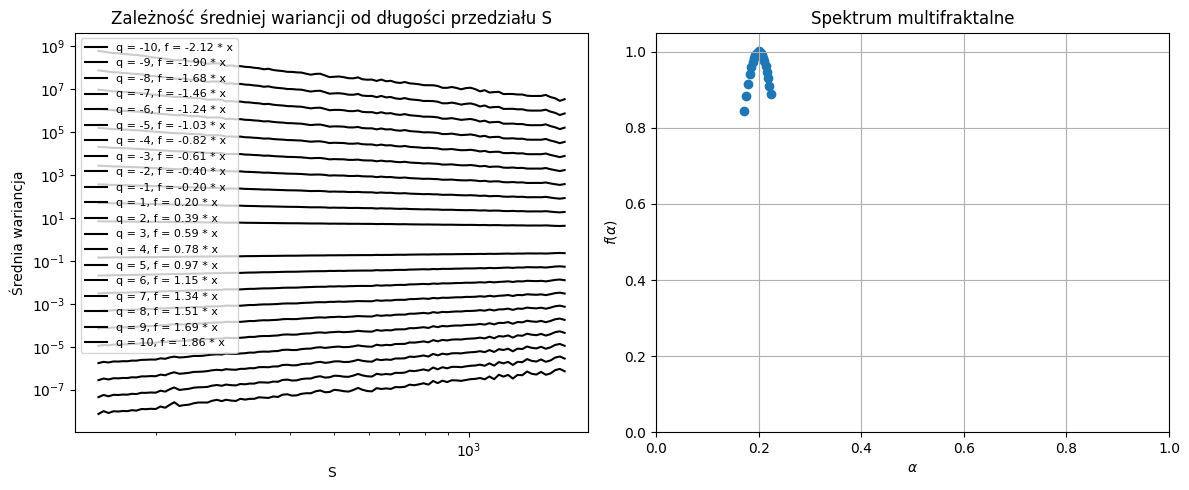

In [52]:
f_02 = FBM(2**15, 0.2)
f_02_sample = f_02.fbm()

multifractal_analysis(f_02_sample)

### Dane giełdowe

In [53]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Studia/SCGiE/data.csv')

data_all = df.iloc[:, 14].dropna().values
print(f"Długość szeregu czasowego: {len(data_all)}")

Długość szeregu czasowego: 912392


100%|██████████| 20/20 [04:22<00:00, 13.11s/it]


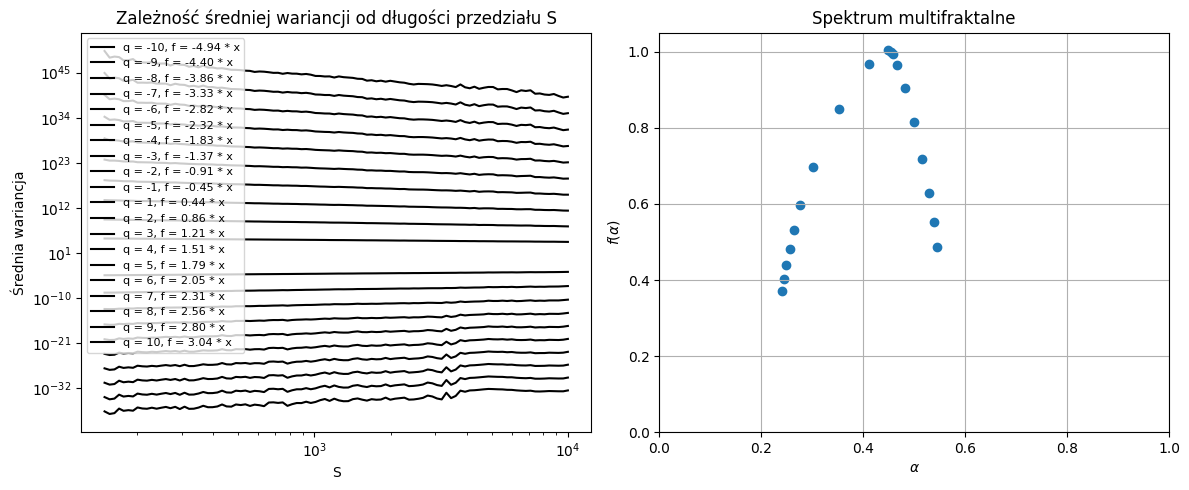

In [55]:
# ze względu na ograniczone możliwości obliczeniowe wybrano fragment danych giełdowych
data = data_all[100000:300000]
multifractal_analysis(data)